In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import os 
import re 
from dotenv import load_dotenv
from amadeus import Client, ResponseError




In [2]:

load_dotenv()

class FlightFinder:
    def __init__(self, originLocationCode, destinationLocationCode, departureDate, adults) -> None:
        self.originLocationCode = originLocationCode
        self.destinationLocationCode = destinationLocationCode
        self.departureDate = departureDate
        self.adults = adults
        self.data = None

    def query_flight(self):
        # Initialize Amadeus client
        amadeus = Client(
            client_id=os.getenv('API_KEY'),
            client_secret=os.getenv('API_SECRET')
        )

        try:
            # Attempt to fetch flight data
            response = amadeus.shopping.flight_offers_search.get(
                originLocationCode=self.originLocationCode,
                destinationLocationCode=self.destinationLocationCode,
                departureDate=self.departureDate,
                adults=self.adults
            )
            # Save the data if successful
            self.data = response.data
            print("Data fetched successfully!")
        
        except ResponseError as error:
            # Log the error details
            print("Error fetching data:", error)
            if hasattr(error, 'response'):
                print("Response:", error.response)
    




In [3]:
class FlightDataProcessor:

    def __init__(self,data):
        self.data = data
    
    
    def normalize_data(self):
        if self.data:
            return pd.json_normalize(self.data)
        
        else:
            raise ValueError("No data to normalize")
    
    
    def to_csv(self,filepath,df):
        return df.to_csv(filepath)
    



    def clean_load_itineraries(self, df):
        flight_info = []
        for i, row in df.loc[:, ['itineraries']].iterrows():
        # Correctly format the JSON string
            row['itineraries'] = json.dumps(row['itineraries'])
            row['itineraries'] = row['itineraries'].replace("'", '"')
            row['itineraries'] = re.sub(r'\bFalse\b', 'false', row['itineraries'])
        
        # Update only the 'itineraries' column for the current row
            df.at[i, 'itineraries'] = row['itineraries']
        
        # Parse the cleaned JSON string
            parsed_data = df['itineraries'].iloc[i]
            final_data = json.loads(parsed_data)
        
        # Append the parsed data to flight_info list
            flight_info.append(final_data)
    
        return flight_info


    
    
    def extract_flights(self, data, df):
        l = []
    
    # Loop through each flight data
        for f in data:
            segments = f[0]['segments']
            l.append(segments)
    
    # Create a DataFrame from the list of segments
        df1 = pd.DataFrame(l)

    # Initialize list for normalized columns
        normalized_cols = []
    
    # Iterate through each column in df1
        for i, col in enumerate(df1):
        # Normalize the nested JSON and add suffix for each segment
            normalized_col = pd.json_normalize(df1[i]).apply(pd.Series)
            normalized_col = normalized_col.add_suffix(f'_{i}')
            normalized_cols.append(normalized_col)
    
    # Concatenate all the normalized columns into a single DataFrame
        normalized_df = pd.concat(normalized_cols, axis=1)
    
    # Add the additional columns from the original DataFrame (df)
        normalized_df['additionalServices'] = df['price.additionalServices']
        normalized_df['includedCheckedBagsOnly'] = df['pricingOptions.includedCheckedBagsOnly']
        normalized_df['grandTotal'] = df['price.grandTotal']
        normalized_df['currency'] = df['price.currency']
        normalized_df['lastTicketingDate'] = df['lastTicketingDate']
        normalized_df['lastTicketingDateTime'] = df['lastTicketingDateTime']
        
        return normalized_df

  
    
    def process_additional_services(self, df):
    # Replace single quotes with double quotes for JSON parsing
        df['additionalServices'] = df['additionalServices'].apply(
        lambda x: x.replace("'", '"') if isinstance(x, str) else x
    )
    
    # Convert JSON strings to dictionaries
        df['additionalServices'] = df['additionalServices'].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )
    
    # Explode the column to expand lists into rows
        df = df.explode('additionalServices')
    
    # Use json_normalize directly on 'additionalServices' to flatten the dictionary
        additional_services_df = pd.json_normalize(df['additionalServices'])
    
    # Combine the flattened data with the original DataFrame, dropping the original column
        df = pd.concat([df.reset_index(drop=True), additional_services_df.reset_index(drop=True)], axis=1)
    
        return df.drop(columns=['additionalServices'], axis=1)
    
    def create_itineraries_directory_and_save_csv(df, directory='itineraries', file_name='flights_data.csv'):
            
            if not os.path.exists(directory):
                os.makedirs(directory)

    # Define file path
            file_path = os.path.join(directory, file_name)

    # Save DataFrame as CSV
            df.to_csv(file_path, index=False)

            print(f'CSV file saved to {file_path}')
    
    def plot_grand_total_vs_flight_number(df, directory='itineraries', file_name='grand_total_vs_flight_number.png'):
    # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Define file path for the plot
        plot_file_path = os.path.join(directory, file_name)

    # Plot
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x=df.index, y=df['grandTotal'], color='red')
        plt.title('Grand Total vs. Flight Number')
        plt.xlabel('Flight Number')
        plt.ylabel('Grand Total in (€)')
        plt.gca().invert_yaxis()
        plt.tight_layout()

    # Save the plot before showing it
        plt.savefig(plot_file_path)

    # Show the plot
        plt.show()

    # Close the plot to free up memory
        plt.close()

        print(f'Plot saved to {plot_file_path}')
         




In [4]:
finder = FlightFinder(originLocationCode='AYT', destinationLocationCode='BCN', departureDate='2024-09-01', adults=1)

In [5]:
finder.query_flight()

Data fetched successfully!


In [6]:
processor = FlightDataProcessor(finder.data)

In [7]:
df = processor.normalize_data()

In [8]:
flight_infos = processor.clean_load_itineraries(df)

In [9]:
df_flights = processor.extract_flights(flight_infos,df)

In [10]:
final_df = processor.process_additional_services(df_flights)

In [11]:
final_df = final_df.fillna('-')

In [12]:
final_df


,carrierCode_0,number_0,duration_0,id_0,numberOfStops_0,blacklistedInEU_0,departure.iataCode_0,departure.terminal_0,departure.at_0,arrival.iataCode_0,...,arrival.at_1,aircraft.code_1,operating.carrierCode_1,includedCheckedBagsOnly,grandTotal,currency,lastTicketingDate,lastTicketingDateTime,amount,type
0,EW,929,PT3H55M,13,0,False,AYT,1,2024-09-01T12:05:00,CGN,...,2024-09-01T20:10:00,73H,QS,True,183.89,EUR,2024-08-15,2024-08-15,-,-
1,XQ,186,PT4H,41,0,False,AYT,-,2024-09-01T11:10:00,DUS,...,2024-09-01T20:35:00,321,LH,True,185.61,EUR,2024-08-17,2024-08-17,-,-
2,EW,2925,PT3H35M,5,0,False,AYT,1,2024-09-01T11:05:00,STR,...,2024-09-01T20:05:00,320,4X,True,188.78,EUR,2024-08-15,2024-08-15,-,-
3,XQ,132,PT3H25M,105,0,False,AYT,-,2024-09-01T15:35:00,MUC,...,2024-09-01T21:30:00,320,LH,True,189.23,EUR,2024-08-17,2024-08-17,-,-
4,XQ,130,PT3H25M,91,0,False,AYT,-,2024-09-01T10:00:00,MUC,...,2024-09-01T17:45:00,320,LH,True,189.23,EUR,2024-08-17,2024-08-17,-,-
5,XQ,134,PT3H25M,99,0,False,AYT,-,2024-09-01T07:00:00,MUC,...,2024-09-01T14:50:00,320,LH,True,189.23,EUR,2024-08-17,2024-08-17,-,-
6,XQ,136,PT3H25M,3,0,False,AYT,-,2024-09-01T13:30:00,MUC,...,2024-09-01T21:30:00,320,LH,True,189.23,EUR,2024-08-17,2024-08-17,-,-
7,XQ,140,PT3H50M,45,0,False,AYT,-,2024-09-01T16:35:00,FRA,...,2024-09-01T23:05:00,321,LH,True,197.65,EUR,2024-08-17,2024-08-17,-,-
8,XQ,142,PT3H50M,27,0,False,AYT,-,2024-09-01T15:50:00,FRA,...,2024-09-01T23:05:00,321,LH,True,197.65,EUR,2024-08-17,2024-08-17,-,-
9,XQ,144,PT3H50M,53,0,False,AYT,-,2024-09-01T07:50:00,FRA,...,2024-09-01T15:20:00,320,LH,True,197.65,EUR,2024-08-17,2024-08-17,-,-


In [13]:
FlightDataProcessor.create_itineraries_directory_and_save_csv(final_df)

CSV file saved to itineraries/flights_data.csv


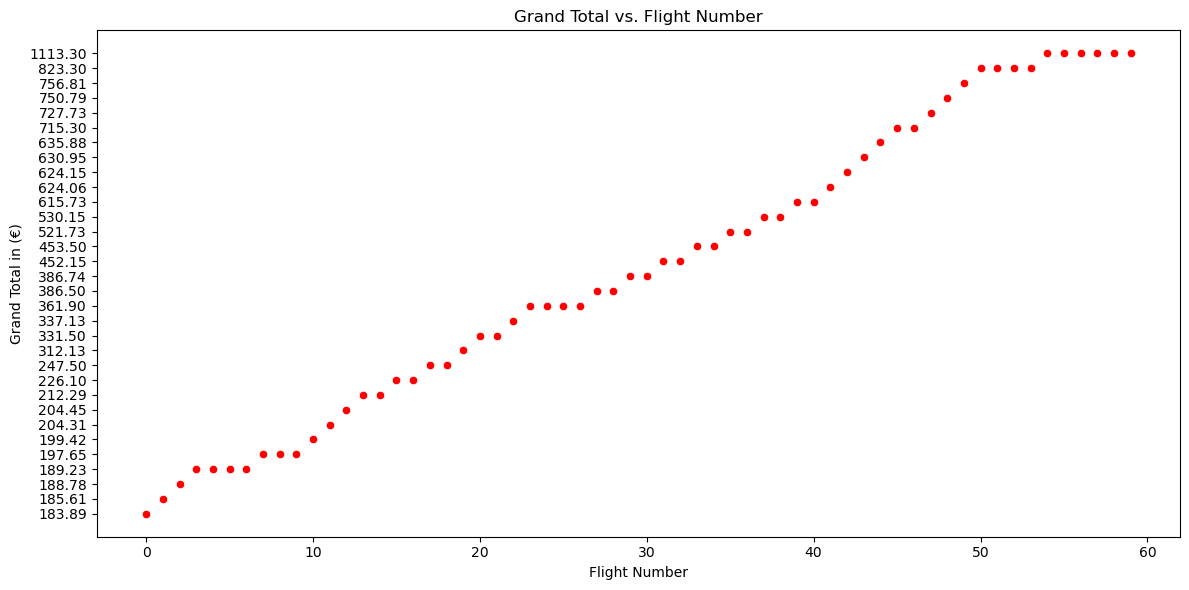

Plot saved to itineraries/grand_total_vs_flight_number.png


In [14]:
FlightDataProcessor.plot_grand_total_vs_flight_number(final_df)